# PPO step by step

In [3]:
from argparse import ArgumentParser
import numpy as np
import wandb
from gridworld_ctf_mvp import GridworldCtf
import os
import time
import torch as T
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from torch.distributions.categorical import Categorical
import utils as ut
import multiprocessing as mp

## Policy Network

In [46]:
class PolicyNet(nn.Module):
    def __init__(self, n_channels=4, n_actions=8, alpha=0.0003):
        super(PolicyNet, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*2*2 + 12, 256)
        self.action_head = nn.Linear(256, n_actions)
        self.value_head = nn.Linear(256, 1)
        self.optimizer = Adam(self.parameters(), lr=alpha)

        self.action_head.weight.data.fill_(0.0)
        self.value_head.weight.data.fill_(0.0)
        
    def forward(self, x, x2, print_shapes=False):
        if print_shapes:
            print(f'input shape: {x.shape}')

        x = T.relu(self.conv1(x))
        if print_shapes:
            print(f'shape after conv 1: {x.shape}')
        
        x = T.relu(self.conv2(x))
        if print_shapes:
            print(f'shape after conv 2: {x.shape}')
        
        x = x.view(-1, 32*2*2)
        if print_shapes:
            print(f'shape after flattening: {x.shape}')

        # Add in metadata
        x = T.concat((x, x2), dim=1)
        if print_shapes:
            print(f'shape after adding metadata: {x.shape}')
        
        x = T.relu(self.fc1(x))
        if print_shapes:
            print(f'shape after FC layer: {x.shape}')
        
        action_scores = T.softmax(self.action_head(x), dim=-1)
        if print_shapes:
            print(f'action scores shape: {action_scores.shape}')

        state_values = self.value_head(x)
        if print_shapes:
            print(f'state values shape: {state_values.shape}')

        # Categorical below samples an action according to the  

        return Categorical(action_scores).sample(), action_scores, state_values
        

In [65]:
pn = PolicyNet(n_channels=5)

x = T.randn((1, 5, 6, 6))
x2 = T.randn((1, 12))

print(x)
print(x2)

tensor([[[[ 9.0105e-01,  8.8071e-01,  9.9161e-02,  8.4424e-01,  1.3556e+00,
            7.2633e-01],
          [-6.0907e-01, -4.7004e-01, -6.2230e-01, -9.1117e-01,  1.4803e+00,
           -5.1111e-01],
          [-9.5306e-01,  5.3970e-01,  1.0382e+00,  3.0276e-01, -8.6736e-01,
            6.6830e-01],
          [ 2.1302e-01,  4.1352e-01, -1.4238e+00, -8.1579e-01,  1.2617e+00,
            1.0434e+00],
          [ 3.4611e-01, -3.8493e-01,  1.3110e-02,  4.7143e-01, -9.7373e-02,
           -5.1921e-01],
          [ 9.4590e-03,  1.2614e+00, -7.2829e-01, -1.0665e+00,  3.6353e-01,
           -4.2868e-01]],

         [[-2.7000e-01, -1.2078e+00, -7.0416e-01, -6.5911e-01,  4.1710e-01,
           -1.7907e-01],
          [ 2.8265e-01, -9.6100e-01,  4.8169e-01,  2.1039e-01,  5.5740e-01,
            3.2149e-01],
          [ 1.5748e+00, -8.4067e-01,  7.5193e-01, -6.7163e-01, -1.9647e+00,
           -2.6164e-01],
          [-3.6297e-01, -7.7888e-01,  8.1567e-01, -3.4932e-01,  4.8459e-02,
            2

In [66]:
action, probs, value = pn(x, x2, print_shapes=True)

print()
print(action)
print(probs)
print(value)

input shape: torch.Size([1, 5, 6, 6])
shape after conv 1: torch.Size([1, 16, 4, 4])
shape after conv 2: torch.Size([1, 32, 2, 2])
shape after flattening: torch.Size([1, 128])
shape after adding metadata: torch.Size([1, 140])
shape after FC layer: torch.Size([1, 256])
action scores shape: torch.Size([1, 8])
state values shape: torch.Size([1, 1])

tensor([5])
tensor([[0.1261, 0.1250, 0.1309, 0.1192, 0.1196, 0.1248, 0.1281, 0.1263]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.0051]], grad_fn=<AddmmBackward0>)


## Environment

In [67]:
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False
        }

env = GridworldCtf(**config)

env.ACTION_SPACE

8

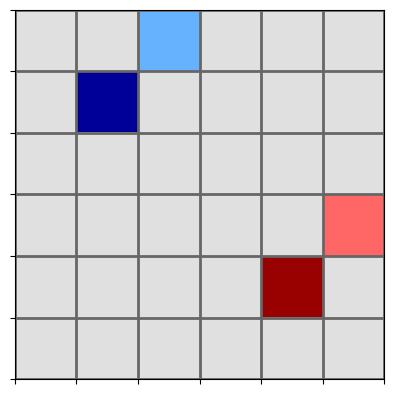

In [68]:
env.render()

In [69]:
env.standardise_state(0)

array([[[[0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]]], dtype=uint8)

In [70]:
metadata_local = env.get_env_metadata_local(0)
print(metadata_local)
print(metadata_local.shape)

[[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]]
(1, 12)


In [71]:
metadata_global = env.get_env_metadata_global([0, 0])
print(metadata_global)
print(metadata_global.shape)

[[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]]
(1, 28)


## PPO Agent

In [150]:
class PPOAgent:
    def __init__(self, 
                 n_epochs,
                 batch_size,
                 alpha,
                 n_actions, 
                 grid_size=6, 
                 n_channels=5,
                 c1=1.0,
                 c2=0.01,
                 epsilon=0.2,
                 device="cpu",
                 normalise_rewards=True):

        # Store attributes
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.alpha = alpha
        self.n_actions = n_actions 
        self.grid_size = grid_size 
        self.n_channels = n_channels
        self.c1 = c1
        self.c2 = c2
        self.epsilon = epsilon
        self.device = device
        self.normalise_rewards = normalise_rewards

        # Init annealing schedule and memory buffer
        self.memory = []
        
        # Build actor and critic networks
        self.policy_network = PolicyNet(alpha=self.alpha,
                                        n_channels=n_channels,
                                        n_actions=n_actions)

    def choose_action(self, state, state2):
        action, probs, value = self.policy_network(state, state2)

        return action, probs, value

    def shuffle_memory(self):
        np.random.shuffle(self.memory)

    def clear_memory(self):
        self.memory = []

    def compute_cumulative_rewards(self, gamma):
        """Given a buffer with states, policy action logits, rewards and terminations,
        computes the cumulative rewards for each timestamp and substitutes them into the buffer."""
        curr_rew = 0.0

        # Getting the average reward before normalizing (for logging and checkpointing)
        avg_rew = np.mean([self.memory[i][-2] for i in range(len(self.memory))])

        # Traversing the buffer on the reverse direction
        for i in range(len(self.memory) - 1, -1, -1):
            r, t = self.memory[i][-2], self.memory[i][-1]

            if t:
                curr_rew = r
            else:
                curr_rew = r + gamma * curr_rew

            self.memory[i][-2] = curr_rew

        # Normalizing cumulative rewards
        if self.normalise_rewards:
            mean = np.mean([self.memory[i][-2] for i in range(len(self.memory))])
            std = np.std([self.memory[i][-2] for i in range(len(self.memory))]) + 1e-6
            for i in range(len(self.memory)):
                self.memory[i][-2] = (self.memory[i][-2] - mean) / std

        return avg_rew

    def get_losses(self, batch, annealing=1.0):
        """Returns the three loss terms for a given model and a given batch and additional parameters"""
        # Getting old data
        n = len(batch)
        states = T.cat([batch[i][0] for i in range(n)])
        states2 = T.cat([batch[i][1] for i in range(n)])
        actions = T.cat([batch[i][2] for i in range(n)]).view(n, 1)

        logits = T.cat([batch[i][3] for i in range(n)])
        values = T.cat([batch[i][4] for i in range(n)])

        cumulative_rewards = T.tensor([batch[i][-2] for i in range(n)]).view(-1, 1).float().to(self.device)

        # Computing predictions with the new model
        _, new_logits, new_values = self.choose_action(states, states2)

        # Loss on the state-action-function / actor (L_CLIP)
        advantages = cumulative_rewards - values
        margin = self.epsilon * annealing
        ratios = new_logits.gather(1, actions) / logits.gather(1, actions)

        # print(f'states shape: {states.shape}')
        # print(f'states2 shape: {states2.shape}')
        # print(f'actions shape (before view): {T.cat([batch[i][2] for i in range(n)]).shape}')
        # print(f'actions shape: {actions.shape}')
        # print(f'logits shape: {logits.shape}')
        # print(f'values shape: {values.shape}')
        # print(f'logits: {batch[:][3]}')
        # print(f'advantages shape: {advantages.shape}')
        # print(f'ratios shape: {ratios.shape}')
        # print(breakit)

        l_clip = T.mean(
            T.min(
                T.cat(
                    (ratios * advantages,
                    T.clip(ratios, 1 - margin, 1 + margin) * advantages),
                    dim=1),
                dim=1
            ).values
        )

        # Loss on the value-function / critic (L_VF)
        l_vf = T.mean((cumulative_rewards - new_values) ** 2)

        # Bonus for entropy of the actor
        entropy_bonus = T.mean(T.sum(-new_logits * (T.log(new_logits + 1e-5)), dim=1))

        return l_clip, l_vf, entropy_bonus

    def learn(self):
        
        # Shuffle memory bugger
        self.shuffle_memory()

        # Running optimization for a few epochs
        for _ in range(self.n_epochs):
            for batch_idx in range(len(self.memory) // self.batch_size):
             
                # Getting batch for this buffer
                start = self.batch_size * batch_idx
                end = start + self.batch_size if start + self.batch_size < len(self.memory) else -1
                batch = self.memory[start:end]

                # Zero-ing optimizers gradients
                self.policy_network.optimizer.zero_grad()

                # Getting the losses
                l_clip, l_vf, entropy_bonus = self.get_losses(batch)

                # Computing total loss and back-propagating it
                loss = l_clip - self.c1 * l_vf + self.c2 * entropy_bonus
                loss.backward()

                # Optimizing
                self.policy_network.optimizer.step()
                
            # self.policy_network.scheduler.step()

        # Clear memory buffer
        self.clear_memory()

        return loss, l_clip, l_vf, entropy_bonus

In [151]:
class PPOOpponent:
    def __init__(self, 
                 n_channels,
                 n_actions,
                 weights):

        # Build polcicy network
        self.policy_network = PolicyNet(n_channels=n_channels, n_actions=n_actions)
        self.policy_network.load_state_dict(weights)

    def choose_action(self, state, state2):
        action, probs, value = self.policy_network(state, state2)

        probs = T.squeeze(probs)[action].item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value


## Collect Experiences

In [152]:
@T.no_grad()
def run_timestamps(env, 
                   agent, 
                   opponent,
                   timestamps=128, 
                   render=False, 
                   device="cpu",
                   iteration=0):
    """Runs the given policy on the given environment for the given amount of timestamps.
     Returns a buffer with state action transitions and rewards."""
    buffer_t1 = []
    env.reset()
    
    total_reward = 0
    # Running timestamps and collecting state, actions, rewards and terminations
    for ts in range(timestamps):
        # Collect actions for each agent
        states = []
        states2 = []
        actions = []
        action_logits = []
        vals = []
        for agent_idx in np.arange(env.N_AGENTS):
            # Get global and local states
            state_ = env.standardise_state(agent_idx, use_ego_state=True)
            state = T.from_numpy(state_).float().to(device) #+ T.randn(*grid_state_local_.shape)

            state2_ = env.get_env_metadata_local(agent_idx)
            state2 = T.from_numpy(state2_).float().to(device)
            
            if env.AGENT_TEAMS[agent_idx]==0:
                action, probs, value = agent.choose_action(state, state2)
            else:
                action, probs, value = opponent.choose_action(state, state2)
                action = 0
            
            # Append actions and probs
            states.append(state)
            states2.append(state2)
            actions.append(action)
            action_logits.append(probs) #TODO: Check in other implementation if logits == probs
            vals.append(value)

        # Step the environment
        _, reward, done = env.step(actions)

        # Rendering / storing (s, a, r, t) in the buffer
        if render and ts < 15 and iteration % 10 == 0 and iteration > 0:
            # total_reward += reward[0]
            env.render(sleep_time=0.01)
            # print(f'step: {ts} \treward: {reward} \ttotal reward:{total_reward} \n')

        # Put the agent rollout data into the correct team buffer
        for agent_idx in np.arange(env.N_AGENTS):
            if env.AGENT_TEAMS[agent_idx]==0:
                buffer_t1.append([states[agent_idx], 
                                states2[agent_idx],
                                actions[agent_idx], 
                                action_logits[agent_idx], 
                                vals[agent_idx], 
                                reward[agent_idx], 
                                done])

        # Resetting environment if episode terminated or truncated
        if done:
            env.reset()

    return buffer_t1


In [153]:
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False
        }

env = GridworldCtf(**config)


n_epochs = 3
batch_size = 32
alpha = 0.00003
n_actions = 8

agent_t1 = PPOAgent(n_epochs,
                    batch_size,
                    alpha,
                    n_actions, 
                    grid_size=6, 
                    n_channels=5,
                    c1=1.0,
                    c2=0.01,
                    device="cpu")

agent_t2 = PPOAgent(n_epochs,
                    batch_size,
                    alpha,
                    n_actions, 
                    grid_size=6, 
                    n_channels=5,
                    c1=1.0,
                    c2=0.01,
                    device="cpu")

buffer = run_timestamps(env, 
                        agent_t1, 
                        agent_t2,
                        timestamps=128, 
                        render=False, 
                        device="cpu")

In [154]:
buffer[0]

[tensor([[[[0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 1.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.]],
 
          [[0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0.

## Training Loop

In [155]:
def training_loop(env, 
                    agent, 
                    opponent, 
                    max_iterations, 
                    n_actors, 
                    horizon, 
                    gamma, 
                    device, 
                    use_mp=False,
                    use_wandb=False,
                    render=False):
    """Train the model on the given environment using multiple actors acting up to n timestamps."""

    # Training variables
    max_reward = float("-inf")

    # global results
    def collect_result(result):
        results.append(result)

    # Training loop
    for iteration in range(max_iterations):
        # Collecting timestamps for all actors with the current policy
        if use_mp:
            results = []
            pool = mp.Pool(mp.cpu_count())
            for _ in range(n_actors):
                pool.apply_async(run_timestamps, 
                                args=(env, agent, opponent, horizon, render, device),
                                callback=collect_result)   
            pool.close()
            pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

            # for i in range(n_actors):
            #     buffer.extend(results[i])
        else:
            for _ in range(n_actors):
                new_buffer_data = run_timestamps(env, agent, opponent, horizon, render, device, iteration)
                agent.memory.extend(new_buffer_data)

        # Computing cumulative rewards and shuffling the buffer
        avg_rew = agent.compute_cumulative_rewards(gamma)

        # Learn over epochs
        loss, l_clip, l_vf, entropy_bonus = agent.learn()

        log = f"Iteration {iteration + 1} / {max_iterations}: " \
              f"Average Reward: {avg_rew:.2f}\t" \
              f"Loss: {loss.item():.3f} " \
              f"(L_CLIP: {l_clip.item():.1f} | L_VF: {l_vf.item():.1f} | L_bonus: {entropy_bonus.item():.1f})" 
        if avg_rew > max_reward:
            # T.save(model.state_dict(), MODEL_PATH)
            max_reward = avg_rew
            log += " --> Stored model with highest average reward"
        print(log)

        # Logging information to W&B
        if use_wandb:
            wandb.log({
                "average reward": avg_rew,
                "loss (total)": loss.item(),
                "loss (clip)": l_clip.item(),
                "loss (vf)": l_vf.item(),
                "loss (entropy bonus)": entropy_bonus.item()
            })

    # Finishing W&B session
    if use_wandb:
        wandb.finish()

## Training

In [156]:
def get_device():
    """Gets the device (GPU if any) and logs the type"""
    if T.cuda.is_available():
        device = T.device("cuda")
        print(f"Found GPU device: {T.cuda.get_device_name(device)}")
    # elif T.backends.mps.is_available() and T.backends.mps.is_built():
    #      device = T.device("mps")
    #      print(f"Found GPU device: {T.cuda.get_device_name(device)}")
    else:
        device = T.device("cpu")
        print("No GPU found: Running on CPU")
    return device

get_device()

No GPU found: Running on CPU


device(type='cpu')

In [157]:
# Parsing program arguments
args = {}

args["use_wandb"] = False
args["max_iterations"] = 100
args["n_actors"] = 8
args["horizon"] = 512
args["epsilon"] = 0.1
args["n_epochs"] = 3
args["batch_size"] = 512
args["lr"] = 0.00003
args["gamma"] = 0.96
args["c1"] = 0.5
args["c2"] = 0.1
args["n_test_episodes"] = 1
args["seed"] = 0
args["use_mp"] = False
args["render"] = True
args["normalise_rewards"] = False


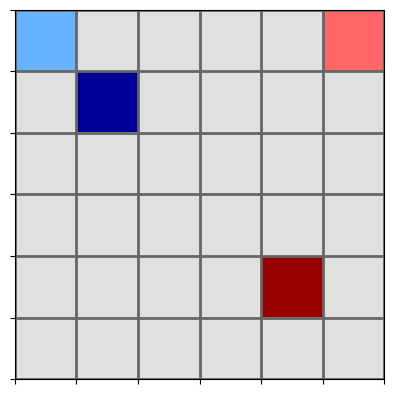

Iteration 91 / 100: Average Reward: -1.00	Loss: 0.725 (L_CLIP: -0.0 | L_VF: 1.5 | L_bonus: 0.0)
Iteration 92 / 100: Average Reward: -1.00	Loss: 1.223 (L_CLIP: 0.0 | L_VF: 2.4 | L_bonus: 0.0)
Iteration 93 / 100: Average Reward: -1.00	Loss: 1.360 (L_CLIP: 0.1 | L_VF: 2.6 | L_bonus: 0.0)
Iteration 94 / 100: Average Reward: -1.00	Loss: 1.341 (L_CLIP: 0.0 | L_VF: 2.7 | L_bonus: 0.0)
Iteration 95 / 100: Average Reward: -1.00	Loss: 0.913 (L_CLIP: 0.0 | L_VF: 1.8 | L_bonus: 0.0)
Iteration 96 / 100: Average Reward: -1.00	Loss: 0.246 (L_CLIP: -0.1 | L_VF: 0.6 | L_bonus: 0.0)
Iteration 97 / 100: Average Reward: -1.00	Loss: 1.240 (L_CLIP: 0.0 | L_VF: 2.4 | L_bonus: 0.0)
Iteration 98 / 100: Average Reward: -1.00	Loss: 1.567 (L_CLIP: 0.1 | L_VF: 3.0 | L_bonus: 0.0)
Iteration 99 / 100: Average Reward: -1.00	Loss: 1.006 (L_CLIP: 0.0 | L_VF: 2.0 | L_bonus: 0.0)
Iteration 100 / 100: Average Reward: -1.00	Loss: 1.341 (L_CLIP: 0.0 | L_VF: 2.6 | L_bonus: 0.0)


In [159]:
# Setting seed
# pl.seed_everything(args["seed"])

# Getting device
device = get_device()

# Init environment
env_name = "Multi-Agent-GW-CTF"
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False,
            'GLOBAL_REWARDS': False
        }

env = GridworldCtf(**config)
env.AGENT_TYPE_DAMAGE = {
    0: 0,
    1: 0,
    2: 0
}
env.REWARD_CAPTURE = 100
env.REWARD_STEP = -1
env.WINNING_POINTS = 100
n_actions = env.ACTION_SPACE
n_actions = 4

# Agents
agent = PPOAgent(args["n_epochs"],
                    args["batch_size"],
                    args["lr"],
                    n_actions, 
                    grid_size=6, 
                    n_channels=5,
                    c1=args["c1"],
                    c2=args["c2"],
                    epsilon=args["epsilon"],
                    device="cpu",
                    normalise_rewards=args["normalise_rewards"])

opponent = PPOOpponent(n_channels=5,
                        n_actions=n_actions,
                        weights=agent.policy_network.state_dict())
    
# Starting a new Weights & Biases run
if args["use_wandb"]:
    wandb.init(project="MARL-CTF-GW",
            name=f"PPO - {env_name}",
            config={
                "env": str(env),
                "grid_size": env.GRID_SIZE,
                "n_agents": env.N_AGENTS,
                "number of actors": args["n_actors"],
                "horizon": args["horizon"],
                "gamma": args["gamma"],
                "epsilon": args["epsilon"],
                "epochs": args["n_epochs"],
                "batch size": args["batch_size"],
                "learning rate": args["lr"],
                "c1": args["c1"],
                "c2": args["c2"]
            })

# Training
training_loop(env, 
                agent, 
                opponent,
                args["max_iterations"], 
                args["n_actors"], 
                args["horizon"], 
                args["gamma"], 
                device, 
                args["use_mp"],
                args["use_wandb"],
                args["render"])


### Test model

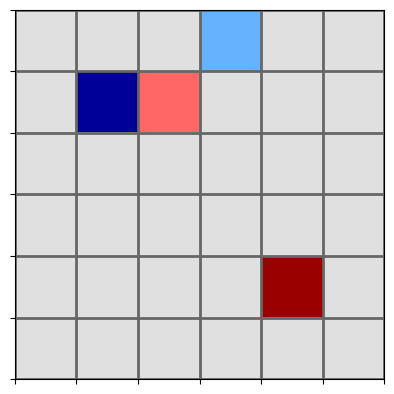

[0, 0]


In [36]:
max_steps = 500
step_count = 0
done= False
device = 'cpu'
env.reset()
total_rewards = 0
while not done:
    step_count += 1

    actions = []
    for agent_idx in np.arange(env.N_AGENTS):
        # Get global and local states
        metadata_state_ = env.get_env_metadata_local(agent_idx) 
        metadata_state = T.from_numpy(metadata_state_).float().to(device)
        
        # Get global and local states
        grid_state_ = env.standardise_state(agent_idx, use_ego_state=use_ego_state)
        grid_state = T.from_numpy(grid_state_).float().to(device)

        #curr_grid_state = env.standardise_state(agent_idx, use_ego_state=use_ego_state, scale_tiles=scale_tiles).reshape(*env_dims) + ut.add_noise(env_dims)

        if env.AGENT_TEAMS[agent_idx]==0:
            action, prob, val = agent.choose_action(grid_state, metadata_state)
        else:
            action, prob, val = opponent.choose_action(grid_state, metadata_state)
            action = 0

        actions.append(action)

    _, rewards, done = env.step(actions)
    total_rewards += rewards[0]

    for agent_idx in np.arange(env.N_AGENTS):
        pass
        # Add reward shaping
        # rewards[agent_idx] += reward_shaping(agent_idx, env)
    env.render(sleep_time=0.01)
    print(step_count, rewards[0], total_rewards)

    if step_count > max_steps:
        done = True


NameError: name 'env' is not defined

In [4]:
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False,
            'GLOBAL_REWARDS': False
        }

env = GridworldCtf(**config)

In [5]:
x =env.standardise_state(0)

In [8]:
x.flatten().shape

(144,)